In [1]:
from pathlib import Path

notebook_dir = Path().resolve()
print(notebook_dir)


C:\Users\Ekta Sharma\Ekta\project\Ecommerce\Analytics


In [2]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from pathlib import Path
import os
cwd_ = os.path.dirname(notebook_dir)
print(cwd_)
# Replace with your actual credentials

try:
    # Step 1: Load environment variables from .env file
    load_dotenv(dotenv_path = cwd_ + '/.env')
    # Step 2: Get the connection parameters from the environment
    db_name = os.getenv("DB_NAME")
    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")
    db_host = os.getenv("DB_HOST")
    db_port = os.getenv("DB_PORT")
    engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")
    #Read a dbt model
    df_dim_user = pd.read_sql("SELECT * FROM opts_hub.dim_user", engine)
    df_dim_product = pd.read_sql("SELECT * FROM opts_hub.dim_user", engine)
    print(df_dim_user.head(1).transpose())
except Exception as e:
    print(e)


C:\Users\Ekta Sharma\Ekta\project\Ecommerce
                                                          0
dim_user_id                                             597
user_hkey                  00a4dfda1470672118655d7f8c3f1363
user_id                                              220422
user_name                                    Maureen Morris
email                  Maureen.Morris.e50c_1699@example.com
phone_number                                     7645520966
address            53103 Joseph Divide\nBellville, MO 10675
birthdate                                        1988-03-29
registration_date                                2020-02-10
valid_from                 2025-06-11 18:40:44.766363+00:00
valid_to                                9999-12-31 00:00:00


In [3]:
# Define Generations by Birth Year
def classify_generation(birthdate):
    birth_year = int(str(birthdate).split('-')[0])
    if pd.isnull(birth_year):
        return 'Unknown'
    elif birth_year >= 2013:
        return 'Gen Alpha'
    elif birth_year >= 1997:
        return 'Gen Z'
    elif birth_year >= 1981:
        return 'Millennials'
    elif birth_year >= 1965:
        return 'Gen X'
    elif birth_year >= 1946:
        return 'Baby Boomers'
    elif birth_year >= 1928:
        return 'Silent Generation'
    else:
        return 'Greatest Generation'
        

df_dim_user['generation'] = df_dim_user['birthdate'].apply(lambda x: classify_generation(x))


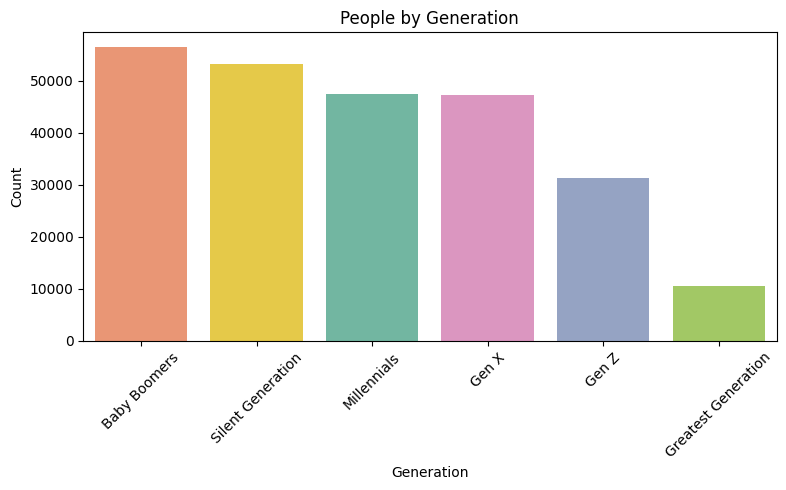

<Figure size 640x480 with 0 Axes>

In [4]:
# Demographic Information: realted to store data
import seaborn as sns
import matplotlib.pyplot as plt
df_gen = df_dim_user[['dim_user_id','generation']].drop_duplicates()
plt.figure(figsize=(8, 5))
sns.countplot(data=df_gen, x='generation',hue='generation', order=df_dim_user['generation'].value_counts().index, palette='Set2',legend=False)
plt.title('People by Generation')
plt.xlabel('Generation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("generation.png")

In [6]:

# Regex pattern to extract parts
pattern = r"^(.*)\n(.+?)[,\s]+([A-Z]{2})\s(\d{5})$"

# Apply regex
df_dim_user[['street', 'city', 'state', 'zip']] = df_dim_user['address'].str.extract(pattern)
df_dim_user[['address','street', 'city', 'state', 'zip']].head(2)

,address,street,city,state,zip
0,"53103 Joseph Divide\nBellville, MO 10675",53103 Joseph Divide,Bellville,MO,10675
1,"728 Sarah Crescent\nEast Kristen, IL 71968",728 Sarah Crescent,East Kristen,IL,71968


In [7]:
#To check if there are null in these columns after extraction
print(df_dim_user[['street', 'city', 'state', 'zip']].isnull().any())


street    False
city      False
state     False
zip       False
dtype: bool


Index(['APO', 'FPO', 'DPO'], dtype='object', name='city')


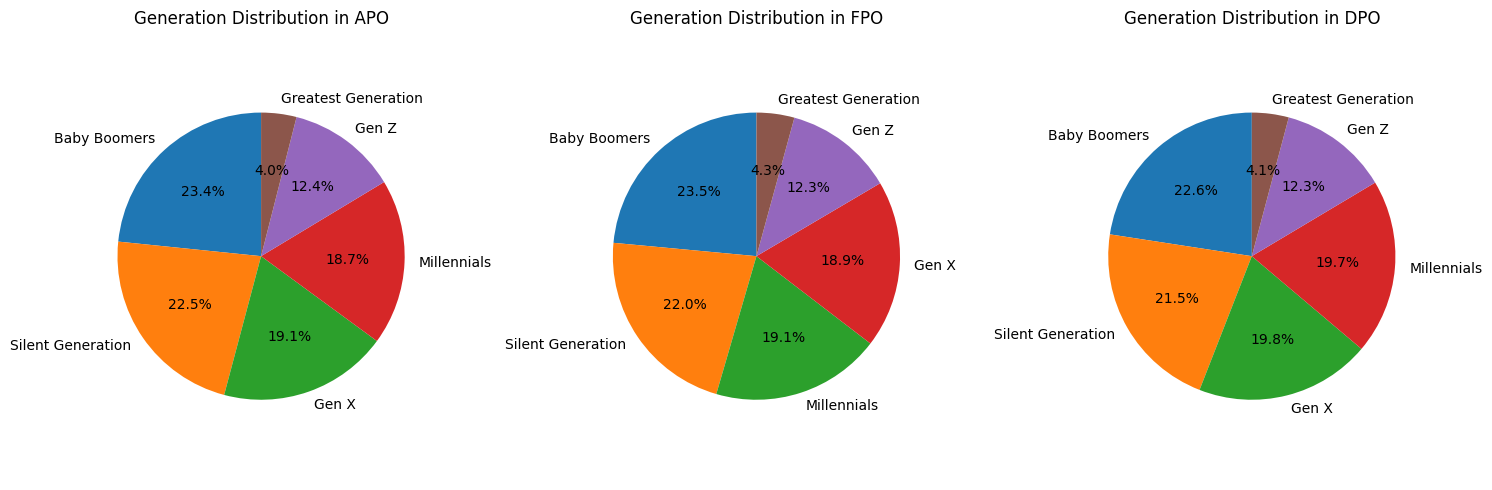

<Figure size 640x480 with 0 Axes>

In [8]:
# top 3 cities by record count - pie chart of the generation distribution
# insights like: In a city, what % are Millennials vs Gen X?
top_countries = df_dim_user['city'].value_counts().nlargest(3).index
print(top_countries)
df_top = df_dim_user[df_dim_user['city'].isin(top_countries)]

fig, axs = plt.subplots(1, len(top_countries), figsize=(15,5))

for ax, country in zip(axs, top_countries):
    gen_counts = df_top[df_top['city'] == country]['generation'].value_counts()
    ax.pie(gen_counts, labels=gen_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Generation Distribution in {country}')
    ax.axis('equal')

plt.tight_layout()
plt.show()
plt.savefig("generation distribution in top 3 cities.png")

Index(['AE', 'AA', 'AP'], dtype='object', name='state')


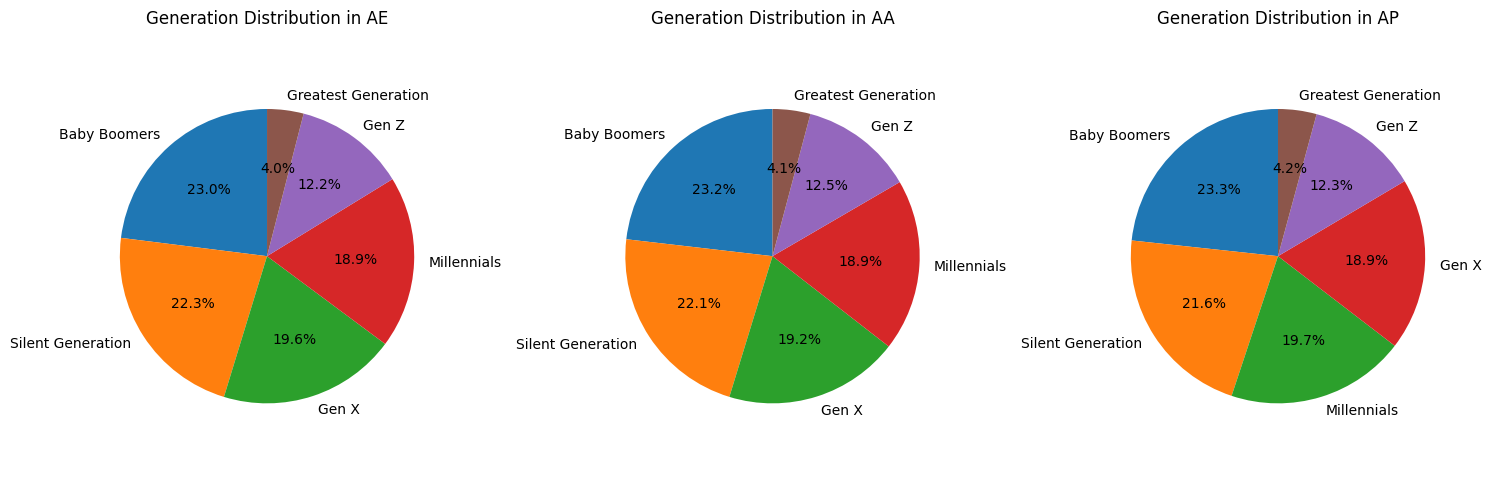

<Figure size 640x480 with 0 Axes>

In [9]:
# top 3 states by record count - pie chart of the generation distribution
# insights like: In a state, what % are Millennials vs Gen X?
top_countries = df_dim_user['state'].value_counts().nlargest(3).index
print(top_countries)
df_top = df_dim_user[df_dim_user['state'].isin(top_countries)]

fig, axs = plt.subplots(1, len(top_countries), figsize=(15,5))
for ax, country in zip(axs, top_countries):
    gen_counts = df_top[df_top['state'] == country]['generation'].value_counts()
    ax.pie(gen_counts, labels=gen_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Generation Distribution in {country}')
    ax.axis('equal')

plt.tight_layout()
plt.show()
plt.savefig("generation distribution in top 3 states.png")

   reg_year  new_users
0      2020      45531
1      2021      45242
2      2022      45166
3      2023      45309
4      2024      45327
5      2025      19633


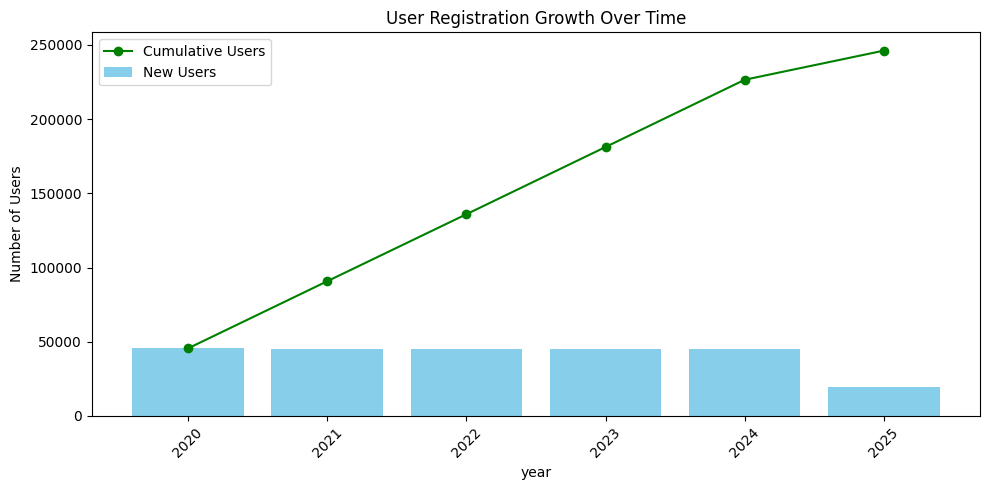

<Figure size 640x480 with 0 Axes>

In [10]:
#Yearly new user registrations & cumulative user growth
# Convert to datetime if needed
df = df_dim_user
df['registration_date'] = pd.to_datetime(df['registration_date'])

# Group by month to count new users
df['reg_year'] = df['registration_date'].dt.year
yearly_new_users = df.groupby('reg_year').agg(new_users=('dim_user_id', 'count')).reset_index()
print(yearly_new_users)
# Cumulative users over time
yearly_new_users['cumulative_users'] = yearly_new_users['new_users'].cumsum()

plt.figure(figsize=(10, 5))

# Bar plot for new users
plt.bar(yearly_new_users['reg_year'], yearly_new_users['new_users'], color='skyblue', label='New Users')

# Line plot for cumulative users
plt.plot(yearly_new_users['reg_year'], yearly_new_users['cumulative_users'], color='green', marker='o', label='Cumulative Users')

plt.title('User Registration Growth Over Time')
plt.xlabel('year')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Yearly new user registrations & cumulative user growth.png")
